# Investment Funds and Risks
## Performance measurement, attribution and risk analysis
## University of Luxembourg
## Juan F. Imbet Ph.D. 

In [30]:
!pip install matplotlib
!pip install tqdm
!pip install statsmodels

In [31]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm
from zipfile import ZipFile
import os

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

In [32]:
base_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/'

# possible datasets
datasets = ['F-F_Research_Data_Factors_CSV.zip',
            '30_Industry_Portfolios_CSV.zip']

# first we download the data, then we read it, then we delete the folders
for dataset in tqdm(datasets):
    # download the data
    url = base_url + dataset
    r = requests.get(url, allow_redirects=True)
    open(dataset, 'wb').write(r.content)
    # read the data
    with ZipFile(dataset, 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall()

100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


In [33]:
with open('30_Industry_Portfolios.CSV') as f:
    for i, line in enumerate(f):
        if line.startswith(','):
            start_ = i
            break
    for j, line in enumerate(f):
        if line == '\n' and j > start_:
            end_ = j
            break

# read the data from start_ to end_
ind_df = pd.read_csv('30_Industry_Portfolios.CSV', skiprows=start_, nrows=end_-start_)
# rename the first column to date and make it the index
ind_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# the year is the first four digits month the last two, make a date
ind_df['date'] = pd.to_datetime(ind_df['date'].astype(str).str[:4] + '-' + ind_df['date'].astype(str).str[-2:])
# move each date to the last day of the month
ind_df['date'] = ind_df['date'] + pd.offsets.MonthEnd(0)

# make date the index
ind_df.set_index('date', inplace=True)

# we dont need the data anymore, so we delete the folder
os.remove('30_Industry_Portfolios.CSV')
os.remove('30_Industry_Portfolios_CSV.zip')

In [34]:
with open('F-F_Research_Data_Factors.CSV') as f:
    for i, line in enumerate(f):
        if line.startswith(','):
            start_ = i
            break
    for j, line in enumerate(f):
        if line == '\n' and j > start_:
            end_ = j
            break

# read the data from start_ to end_
ff_df = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=start_, nrows=end_-start_)
# rename the first column to date and make it the index
ff_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# the year is the first four digits month the last two, make a date
ff_df['date'] = pd.to_datetime(ff_df['date'].astype(str).str[:4] + '-' + ff_df['date'].astype(str).str[-2:])
# move each date to the last day of the month
ff_df['date'] = ff_df['date'] + pd.offsets.MonthEnd(0)

# make date the index
ff_df.set_index('date', inplace=True)

# we dont need the data anymore, so we delete the folder
os.remove('F-F_Research_Data_Factors.CSV')
os.remove('F-F_Research_Data_Factors_CSV.zip')

In [35]:
# merge the two dataframes on the index
df = ind_df.merge(ff_df, left_index=True, right_index=True)
df.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Trans,Whlsl,Rtail,Meals,Fin,Other,Mkt-RF,SMB,HML,RF
date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.56,-5.19,1.29,2.93,10.97,-0.48,8.08,1.77,8.14,0.39,...,1.91,-23.79,0.07,1.87,-0.02,5.20,2.96,-2.56,-2.43,0.22
1926-08-31,2.59,27.03,6.50,0.55,10.01,-3.58,-2.51,4.25,5.50,7.97,...,4.85,5.39,-0.75,-0.13,4.47,6.76,2.64,-1.17,3.82,0.25
1926-09-30,1.16,4.02,1.26,6.58,-0.99,0.73,-0.51,0.69,5.33,2.30,...,0.07,-7.87,0.25,-0.56,-1.61,-3.86,0.36,-1.40,0.13,0.23
1926-10-31,-3.06,-3.31,1.06,-4.76,9.47,-4.68,0.12,-0.57,-4.76,1.00,...,-2.61,-15.38,-2.20,-4.11,-5.51,-8.49,-3.24,-0.09,0.70,0.32
1926-11-30,6.35,7.29,4.55,1.66,-5.80,-0.54,1.87,5.42,5.20,3.10,...,1.61,4.67,6.52,4.33,2.34,4.00,2.53,-0.10,-0.51,0.31


In [36]:
df = df.replace(-99.99, np.nan)
df = df.replace(-999, np.nan)

# make all returns by dividing by 100
df = df/100

- Estimating $\alpha$ and $\beta$ for each industry portfolio

In [37]:
factors = ['Mkt-RF', 'SMB',	'HML', 'RF']
industry_columns = [col for col in df.columns if col not in factors]
# compute the excess returns for each industry
for col in industry_columns:
    df[f"e_{col}"] = df[col] - df['RF']
df.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,e_Telcm,e_Servs,e_BusEq,e_Paper,e_Trans,e_Whlsl,e_Rtail,e_Meals,e_Fin,e_Other
date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0061,0.0900,0.0184,0.0748,0.0169,-0.2401,-0.0015,0.0165,-0.0024,0.0498
1926-08-31,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0797,...,0.0192,0.0177,0.0414,-0.0263,0.0460,0.0514,-0.0100,-0.0038,0.0422,0.0651
1926-09-30,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0230,...,0.0218,0.0202,-0.0004,-0.0577,-0.0016,-0.0810,0.0002,-0.0079,-0.0184,-0.0409
1926-10-31,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0043,-0.0232,-0.0141,-0.0540,-0.0293,-0.1570,-0.0252,-0.0443,-0.0583,-0.0881
1926-11-30,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0310,...,0.0132,0.0346,0.0333,0.0353,0.0130,0.0436,0.0621,0.0402,0.0203,0.0369


In [38]:
# OLS regression
measures = pd.DataFrame(index=industry_columns, columns=['alpha', 'beta', 't_alpha', 't_beta'])
for col in industry_columns:
    y = df[f"e_{col}"]
    X = sm.add_constant(df[factors])
    model = OLS(y, X)
    results = model.fit()
    measures.loc[col, 'alpha'] = results.params['const']
    measures.loc[col, 'beta'] = results.params['Mkt-RF']
    measures.loc[col, 't_alpha'] = results.tvalues['const']
    measures.loc[col, 't_beta'] = results.tvalues['Mkt-RF']

In [39]:
measures

,alpha,beta,t_alpha,t_beta
Food,0.000486,0.749262,0.43199,48.703149
Beer,0.002239,0.864958,1.024877,28.941434
Smoke,0.001609,0.655991,0.792554,23.618723
Games,-0.002084,1.294753,-0.998723,45.373413
Books,-0.004261,1.018638,-2.561642,44.774773
Hshld,0.001271,0.903307,0.885183,46.005339
Clths,0.000346,0.768436,0.195461,31.729925
Hlth,0.001864,0.877383,1.343735,46.239319
Chems,0.001724,1.067887,1.346978,60.98286
Txtls,-0.001429,0.987349,-0.756215,38.211435


In [40]:
# average beta? (must be close to 1)
measures['beta'].mean()

np.float64(0.9853551983986638)

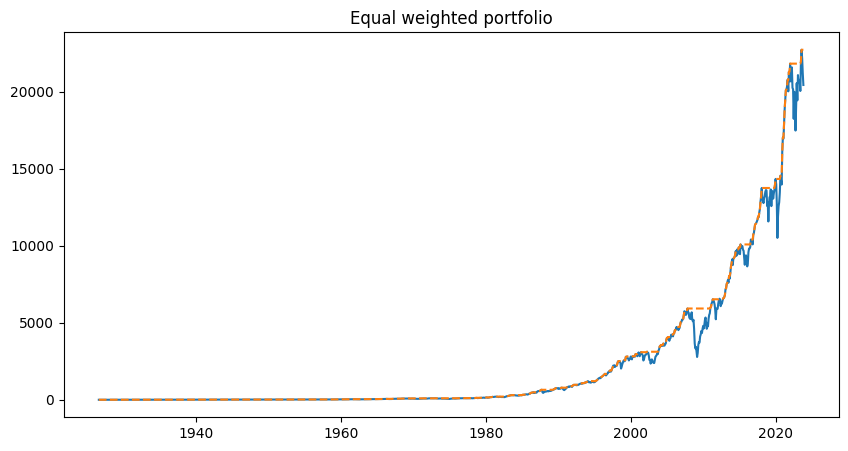

In [48]:
# Equal weighted portfolio across all industries
ew_portfolio = df[industry_columns].mean(axis=1)
# compute the high water mark
ew_portfolio_hwm = (1+ew_portfolio).cumprod().cummax()
# plot cumulative returns
plt.figure(figsize=(10, 5))
plt.plot((1+ew_portfolio).cumprod(), label='Portfolio')
plt.plot(ew_portfolio_hwm, label='High water mark', linestyle='--')
plt.title('Equal weighted portfolio')
plt.show()


In [49]:
# estimate performance ratios, annualized
ew_portfolio = ew_portfolio.dropna()
annual_return = ew_portfolio.mean()*12
annual_std = ew_portfolio.std()*np.sqrt(12)
sharpe = annual_return/annual_std

# display in a table
pd.DataFrame({'Annualized Return': annual_return, 'Annualized Standard Deviation': annual_std, 'Annual Sharpe Ratio': sharpe}, index=['Equal Weighted Portfolio'])



,Annualized Return,Annualized Standard Deviation,Annual Sharpe Ratio
Equal Weighted Portfolio,0.121096,0.193979,0.624276


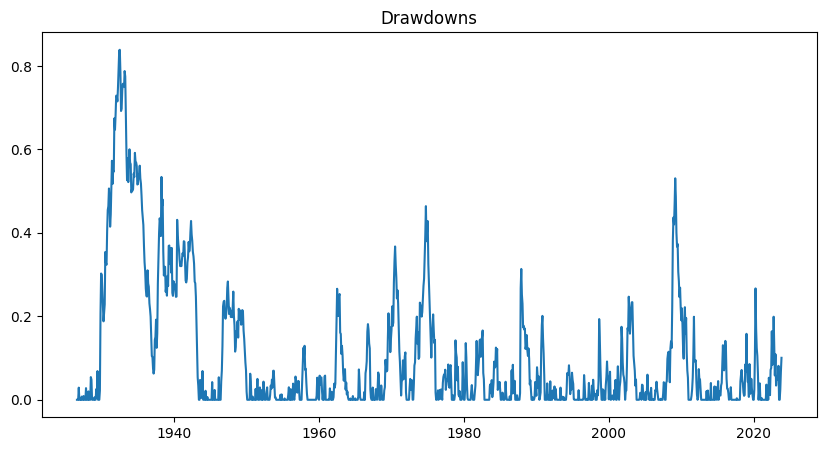

In [50]:
# drawdowns 
P = (1+ew_portfolio).cumprod()
drawdown = 1 - P/P.cummax()
# plot drawdowns
plt.figure(figsize=(10, 5))
plt.plot(drawdown)
plt.title('Drawdowns')
plt.show()

In [51]:
# maximum drawdown
max_drawdown = drawdown.max()
max_drawdown

np.float64(0.8389939921047954)

In [ ]:
# can we do better? Optimize the portfolio on a rolling basis
window = 60 # window for computing moments

# compute rolling mean and covariance matrix 
rolling_mean = df[industry_columns].rolling(window=window).mean()
rolling_cov = df[industry_columns].rolling(window=window).cov()

# drop na values
rolling_mean.dropna(inplace=True)
rolling_cov.dropna(inplace=True)


   



const     0.000486
Mkt-RF    0.749262
SMB      -0.139912
HML       0.053759
RF        0.519808
dtype: float64

In [55]:
rolling_mean

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
1931-06-30,0.005907,0.002520,0.011042,0.001020,0.015785,0.000750,0.001222,0.011027,0.017725,-0.008707,...,0.011838,0.010520,0.012948,0.012107,0.002022,-0.032342,0.003832,0.004588,0.003627,-0.009642
1931-07-31,0.005145,0.001725,0.010245,-0.000933,0.013452,0.000545,-0.000677,0.011167,0.015317,-0.009712,...,0.010888,0.008728,0.010842,0.008703,-0.000042,-0.029728,0.003622,0.002913,0.002177,-0.010222
1931-08-31,0.004958,-0.000477,0.008577,0.000155,0.010745,0.000967,-0.000658,0.010523,0.014628,-0.010988,...,0.010663,0.008423,0.010682,0.009252,-0.001983,-0.030398,0.004265,0.003118,0.001495,-0.011405
1931-09-30,0.000035,-0.005342,0.004750,-0.008023,0.007222,-0.004983,-0.001972,0.005500,0.008670,-0.014972,...,0.006668,0.005272,0.005352,0.006235,-0.005440,-0.033440,-0.000845,-0.001317,-0.004885,-0.015153
1931-10-31,0.002320,-0.000593,0.005587,-0.004067,0.002652,-0.001492,-0.002403,0.007472,0.010282,-0.014677,...,0.007410,0.006007,0.007183,0.009012,-0.005515,-0.029648,0.001888,0.001220,-0.001972,-0.012948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,0.007785,0.009965,0.007775,0.003897,0.003953,0.010492,0.007313,0.008670,0.005545,-0.002885,...,0.002517,0.013148,0.020352,0.001298,0.008427,0.014442,0.010630,0.012797,0.007943,0.010712
2023-07-31,0.007728,0.009915,0.007150,0.005237,0.005368,0.010167,0.007363,0.007663,0.005455,-0.000795,...,0.002227,0.013542,0.020473,0.001172,0.008357,0.013873,0.010595,0.013042,0.008302,0.009843
2023-08-31,0.007158,0.009462,0.007510,0.004127,0.007073,0.009445,0.005510,0.006875,0.004758,-0.002055,...,0.001772,0.012363,0.018618,0.000847,0.006967,0.013003,0.009165,0.011578,0.007293,0.009632


In [60]:
rolling_cov.loc['1940-09-30']

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Food,0.003383,0.004257,0.002334,0.005685,0.005849,0.003728,0.003485,0.002860,0.003730,0.005619,...,0.002483,0.003199,0.003558,0.003970,0.005487,0.004946,0.004296,0.004248,0.004826,0.004865
Beer,0.004257,0.007603,0.002929,0.008026,0.007953,0.004915,0.004263,0.003793,0.004993,0.007584,...,0.003077,0.005924,0.005009,0.005320,0.007175,0.006707,0.006021,0.006055,0.006408,0.006914
Smoke,0.002334,0.002929,0.002220,0.004457,0.003915,0.002818,0.002304,0.002117,0.002643,0.003907,...,0.001898,0.002188,0.002740,0.002603,0.003351,0.003628,0.003295,0.003103,0.003551,0.003607
Games,0.005685,0.008026,0.004457,0.013956,0.010617,0.007003,0.005309,0.004851,0.006652,0.010265,...,0.004769,0.004208,0.007153,0.006324,0.009297,0.009735,0.008388,0.008628,0.008988,0.009954
Books,0.005849,0.007953,0.003915,0.010617,0.013034,0.006950,0.006986,0.005234,0.007346,0.011628,...,0.004325,0.006441,0.006354,0.008092,0.011300,0.009195,0.007898,0.008126,0.009305,0.009453
Hshld,0.003728,0.004915,0.002818,0.007003,0.006950,0.005413,0.004097,0.003450,0.004277,0.006770,...,0.002793,0.002388,0.004025,0.004599,0.006130,0.005845,0.005196,0.004759,0.005544,0.005753
Clths,0.003485,0.004263,0.002304,0.005309,0.006986,0.004097,0.005157,0.003139,0.004462,0.007014,...,0.002524,0.002787,0.003567,0.004974,0.007018,0.005237,0.004472,0.004405,0.005326,0.005025
Hlth,0.002860,0.003793,0.002117,0.004851,0.005234,0.003450,0.003139,0.003000,0.003438,0.005028,...,0.002173,0.002849,0.003173,0.003518,0.004730,0.004510,0.003823,0.003965,0.004237,0.004167
Chems,0.003730,0.004993,0.002643,0.006652,0.007346,0.004277,0.004462,0.003438,0.005706,0.007623,...,0.002936,0.002258,0.004499,0.005219,0.007736,0.006025,0.005245,0.005036,0.006150,0.006139
Txtls,0.005619,0.007584,0.003907,0.010265,0.011628,0.006770,0.007014,0.005028,0.007623,0.011880,...,0.004047,0.004515,0.006463,0.007805,0.011026,0.009265,0.007888,0.007695,0.009042,0.009205


In [109]:
# the risk free rate is the rate in each period in column RF, no need to estimate

# some parameters
u = np.ones(len(industry_columns))
rf = df['RF']
gamma = 2.5

# dataframe to store weights 
weights = pd.DataFrame(index=rolling_mean.index, columns=industry_columns)

for i, date in tqdm(enumerate(rolling_mean.index)):
    if i == 0:
        continue

    # rebalance rules
    # if date.month != 7:
    #    continue

    # one month before 
    date_omf = rolling_mean.index[i-1]
    cov = rolling_cov.loc[date_omf]
    mean = rolling_mean.loc[date_omf]
    # compute the optimal weights
    inv_cov = np.linalg.inv(cov)
    usmu = u.dot(inv_cov).dot(mean)
    usu = u.dot(inv_cov).dot(u)
    rhs = ((usmu-gamma)/usu)*u
    w = (1/gamma)*inv_cov.dot(mean - rhs)

    # no short selling (for fair comparison)
    w = np.maximum(w, 0)
    w = w/w.sum()

    # add the weights to the dataframe
    weights.loc[date] = w

# forward fill the weights
weights.fillna(method='ffill', inplace=True)
weights.dropna(inplace=True)
weights
    

1109it [00:00, 3119.38it/s]
/var/folders/x_/1zjflmcs219d1k_8ylq18hm80000gp/T/ipykernel_5614/2891446465.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weights.fillna(method='ffill', inplace=True)
/var/folders/x_/1zjflmcs219d1k_8ylq18hm80000gp/T/ipykernel_5614/2891446465.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weights.fillna(method='ffill', inplace=True)


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
1931-07-31,0.213075,0.000000,0.083914,0.011748,0.100580,0.022081,0.000000,0.050222,0.167965,0.014887,...,0.000000,0.000000,0.079986,0.040179,0.000000,0.000000,0.027184,0.000000,0.076834,0.000000
1931-08-31,0.203264,0.000000,0.094050,0.010801,0.104314,0.022868,0.000000,0.043585,0.158365,0.007591,...,0.000000,0.000000,0.088203,0.049844,0.000000,0.000000,0.026753,0.000000,0.075951,0.000000
1931-09-30,0.187070,0.000000,0.071299,0.025088,0.087577,0.051759,0.000000,0.021421,0.152112,0.004877,...,0.000000,0.000000,0.058473,0.079024,0.000000,0.000000,0.041987,0.000000,0.088188,0.000000
1931-10-31,0.207536,0.000000,0.060725,0.016577,0.073453,0.030994,0.000000,0.000000,0.110724,0.007477,...,0.060414,0.004157,0.077255,0.048364,0.092436,0.000000,0.069711,0.000000,0.086505,0.000000
1931-11-30,0.194631,0.000000,0.075850,0.030721,0.044734,0.050426,0.000000,0.000000,0.100673,0.000000,...,0.071430,0.008534,0.061779,0.078621,0.085583,0.000000,0.075115,0.000000,0.100313,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.177868,0.049865,0.078687,0.000000,0.000000,...,0.014253,0.093675,0.000000,0.000000,0.000000,0.097672,0.008464,0.000000,0.029730,0.034707
2023-07-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.161098,0.033919,0.102816,0.000000,0.000000,...,0.000000,0.100425,0.000000,0.000000,0.000000,0.040488,0.000000,0.022145,0.077700,0.020176
2023-08-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.135278,0.037899,0.101089,0.000000,0.000000,...,0.000000,0.095222,0.000000,0.000000,0.000000,0.000000,0.000000,0.023961,0.120739,0.000000


In [110]:
# sum of weights should be 1
weights.sum(axis=1)

date
1931-07-31    1.0
1931-08-31    1.0
1931-09-30    1.0
1931-10-31    1.0
1931-11-30    1.0
             ... 
2023-06-30    1.0
2023-07-31    1.0
2023-08-31    1.0
2023-09-30    1.0
2023-10-31    1.0
Length: 1108, dtype: float64

In [111]:
# compute the portfolio returns
rolling_portfolio = (weights*df[industry_columns]).sum(axis=1)

rolling_portfolio

date
1926-07-31    0.000000
1926-08-31    0.000000
1926-09-30    0.000000
1926-10-31    0.000000
1926-11-30    0.000000
                ...   
2023-06-30    0.109411
2023-07-31    0.033226
2023-08-31   -0.020009
2023-09-30   -0.050345
2023-10-31   -0.042895
Length: 1168, dtype: float64

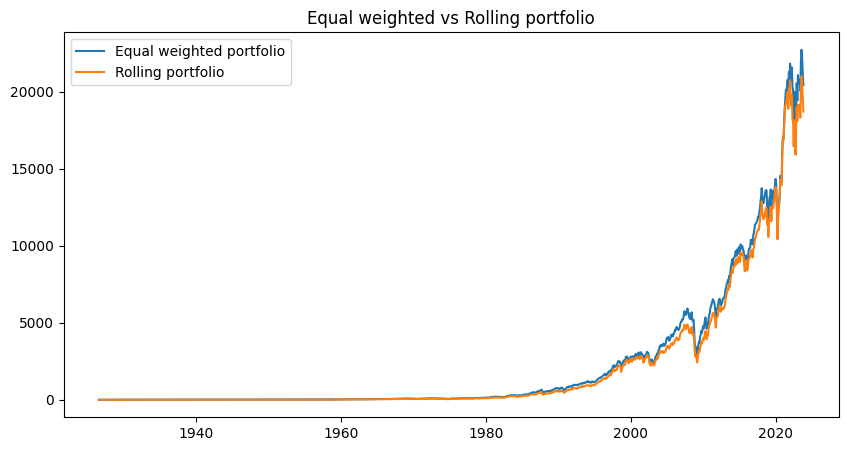

In [112]:
# plot the cumulative returns
# compare with the equal weighted portfolio
plt.figure(figsize=(10, 5))
plt.plot((1+ew_portfolio).cumprod(), label='Equal weighted portfolio')
plt.plot((1+rolling_portfolio).cumprod(), label='Rolling portfolio')
plt.title('Equal weighted vs Rolling portfolio')
plt.legend()
plt.show()

## Example: Market Neutral Strategy

$$
\begin{aligned}
\max_{\theta} \theta'\mu - \frac{\gamma}{2}\theta'\Sigma\theta \\
\text{subject to } \theta'u = 1 \\
B'\theta = 0
\end{aligned}
$$

Compute parameters on a rolling basis

In [115]:
def compute_parameters(df):
    mktrf = df['Mkt-RF']
    # compute market betas
    m_betas = []
    for col in industry_columns:
        y = df[f"e_{col}"]
        X = sm.add_constant(mktrf)
        model = OLS(y, X)
        results = model.fit()
        m_betas.append(results.params['Mkt-RF'])
    
    m_betas = np.array(m_betas)

    # compute expected returns 
    expected_returns = df[industry_columns].mean()

    # compute covariance matrix
    cov = df[industry_columns].cov()

    return m_betas, expected_returns, cov

In [116]:
from scipy.optimize import minimize
def compute_portfolio(m_betas, expected_returns, cov, gamma=2.5):
    obj = lambda w: -w.dot(expected_returns) + gamma/2*w.dot(cov).dot(w)
    # constraints, sum of weights is 1 and market beta is 1
    cons = ({'type': 'eq', 'fun': lambda w: w.sum()-1},
            {'type': 'eq', 'fun': lambda w: w.dot(m_betas)-1})
    
    # initial guess (equal weights)
    w0 = np.ones(len(expected_returns))/len(expected_returns)

    # minimize the objective
    res = minimize(obj, w0, constraints=cons)
    return res.x
    

In [117]:
def split_data(df, date, window):
    # get the data a window before the date except the date 
    # index of the date 
    idx = df.index.get_loc(date)
    # get the data
    data = df.iloc[idx-window:idx]
    return data

In [120]:
# test, last date 
date = df.index[-1]
data = split_data(df, date, window)
print(f"Data from {data.index[0]} to {data.index[-1]}")

# optimize
m_betas, expected_returns, cov = compute_parameters(data)
w = compute_portfolio(m_betas, expected_returns, cov)
w



Data from 2018-10-31 00:00:00 to 2023-09-30 00:00:00


array([-1.40772617,  1.10803176, -0.57806713, -3.80282942, -1.94035202,
        6.25505995,  0.73869971,  1.69714643, -8.22180373, -1.76543334,
        5.44731566,  1.92084315,  8.6584373 , -4.56841597,  1.81860292,
       -1.82749273,  1.30829572,  0.7710558 ,  0.54444226, -1.6397714 ,
       -0.77008245,  6.09634344, -1.88222582, -6.45668542, -3.25127636,
        1.67154758, -2.8674139 , -0.60576907,  3.77700536,  0.77251786])

In [122]:
# Optimization

returns = pd.Series(index=df.index)

for i, date in tqdm(enumerate(df.index)):
    if i < window:
        continue
    data = split_data(df, date, window)
    m_betas, expected_returns, cov = compute_parameters(data)
    w = compute_portfolio(m_betas, expected_returns, cov)
    returns.loc[date] = w.dot(df.loc[date, industry_columns])

returns.dropna(inplace=True)
returns

1168it [03:31,  5.52it/s]


date
1931-07-31    1.561125
1931-08-31    0.460742
1931-09-30   -2.640968
1931-10-31   -0.149421
1931-11-30    0.355223
                ...   
2023-06-30    1.005119
2023-07-31   -0.362298
2023-08-31    0.367614
2023-09-30    0.677369
2023-10-31   -0.057148
Length: 1108, dtype: float64

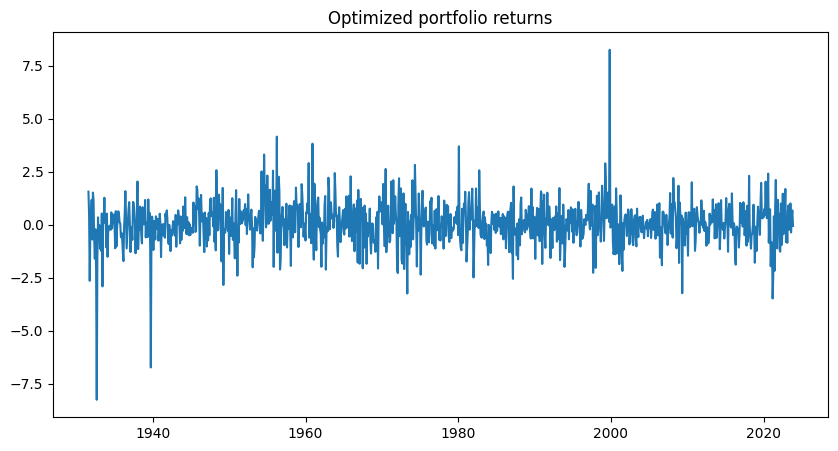

In [125]:
# plot the raw returns
plt.figure(figsize=(10, 5))
plt.plot(returns)
plt.title('Optimized portfolio returns')
plt.show()

In [127]:
# compute the expost beta 
y = returns
X = sm.add_constant(df.loc[returns.index, 'Mkt-RF'])
model = OLS(y, X)
results = model.fit()
market_beta = results.params['Mkt-RF']
t_market_beta = results.tvalues['Mkt-RF']
market_beta

np.float64(0.17744612451905226)